In [1]:
import pandas as pd
# import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy.optimize import minimize, least_squares
import math
import autograd.numpy as np
from autograd import grad, jacobian
from gc_aux import r2_score
from gc_prop_calculation import lhs_cal, y_pred_cal

In [74]:
df1 = pd.read_excel('data/excel_sp/Train_Tc.xlsx')
df2 = pd.read_excel('data/excel_sp/Test_Tc.xlsx')

In [75]:
df_concatenated = pd.concat([df1, df2], ignore_index=True)  

df_concatenated_filtered = df_concatenated.loc[:, (df_concatenated != 0).any(axis=0)]

df1_aft = df_concatenated_filtered.iloc[:len(df1)]  
df2_aft = df_concatenated_filtered.iloc[len(df1):]  

In [76]:
# # load the data
# df_raw = pd.read_excel('data/new_excels/Tc.xlsx')
# # extract target values
# df_target = df_raw['Const_Value']
# # extract all groups
# df_grp = df_raw.loc[:,'CH3':]
# # df_grp = df_raw[df_raw.columns[2:]]
# # extract first order groups and non-zero index
# df_fog = df_grp.iloc[:,:220]
# idx_fog = df_fog.sum(axis=0).to_numpy().nonzero()[0]
# nr_fog = len(idx_fog)
# # extract second order groups and non-zero index
# df_sog= df_grp.iloc[:,220:220+130]
# idx_sog = df_sog.sum(axis=0).to_numpy().nonzero()[0]
# nr_sog = len(idx_sog)
# # extract third order groups and non-zero index
# df_tog = df_grp.iloc[:,220+130:220+130+74]
# idx_tog = df_tog.sum(axis=0).to_numpy().nonzero()[0]
# nr_tog = len(idx_tog)

In [91]:
df_raw = df1_aft
# extract target values
df_target = df_raw['Const_Value']
# extract all groups
df_grp = df_raw.loc[:,'CH3':]

In [92]:
prop_tag = 'Tc'

In [93]:
# extract G
G = df_grp.to_numpy()
# extract y
y = df_target.to_numpy() #*1000

In [94]:
# define universal constant and calculate lhs
uni_const, lhs = lhs_cal(prop_tag, y)

# initialization of theta
theta_ini = theta = np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(G),G)),np.transpose(G)),lhs)

In [95]:
tog_0_r2 = 0
tog_0_mae = 0
tog_0_are = 0
tog_0_mre =0

r2 of tog:0.9315836548402475
are of tog:2.8622014440615624
mre of tog:1.7552069157750192


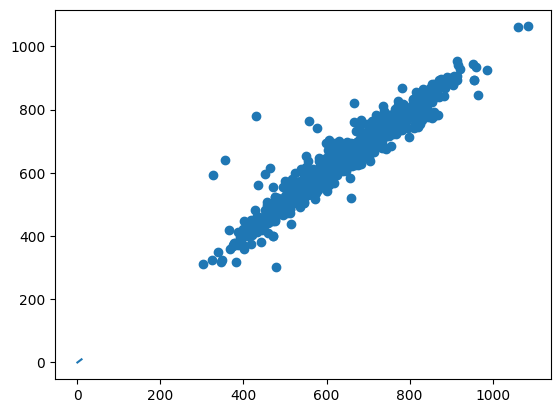

In [96]:
# prediction on each level
# y0_fog = uni_const * np.exp(np.matmul(G[:,:nr_fog],theta_ini[:nr_fog]))
# y0_sog = uni_const * np.exp(np.matmul(G[:,:nr_fog+nr_sog],theta_ini[:nr_fog+nr_sog]))

y0_tog = y_pred_cal(G, uni_const, theta_ini, 0, 0, prop_tag)

# calculate mae and r2 for each level
tog_0_r2 = r2_score(y,y0_tog)
tog_0_mae = mean_absolute_error(y,y0_tog)
tog_0_are = np.average(np.abs((y - y0_tog) / y))*100
tog_0_mre = np.median(np.abs((y - y0_tog) / y))*100
# printing
print('r2 of tog:' + str(tog_0_r2))
print('are of tog:' + str(tog_0_are))
print('mre of tog:' + str(tog_0_mre))

# plot
plt.scatter(y,y0_tog)
plt.plot([0,10],[0,10])
# plt.savefig('Parity Plot of y0_tog and y_true for '+prop_tag+'.pdf')
plt.show()

In [97]:
# define objective function
def fog_sse_lfvl(fog_params, G, y):
    """
    Funtion to calculate the sum of squared errors of the gc model using first order groups
    :param fog_params: group contributions 
    :param G: group occurrence
    :param y: target values
    :return: 
    """
    y_pred = y_pred_cal(G, fog_params[0], fog_params[1:], 0, 0, prop_tag)    
#     y_pred = y_pred_cal(G, [fog_params[0], fog_params[1], fog_params[2]], fog_params[3:], 0, 0, prop_tag)  

    errors = y-y_pred
    sse = np.sum(errors ** 2)
    return sse
# define initial params
fog_ini = np.append(uni_const,theta_ini)
# perform optimization Nelder Mead then L-BFGS-B
result = minimize(fog_sse_lfvl, fog_ini, args=(G, y), jac=None, method='Nelder-Mead',
                  options={'fatol': 1e-6, 'disp': True, 'maxiter': 300000, 'maxfev': 300000})
# perform optimization
result = minimize(fog_sse_lfvl, result.x, args=(G, y), jac=None, method='L-BFGS-B',
                  options={'ftol': 1e-6, 'disp': True, 'maxiter': 300000, 'maxfun': 300000})
result
fog_simp = result.x

D:\Users\49332\anaconda3\envs\test\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\49332\AppData\Local\Temp\ipykernel_27656\3652196155.py:19: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fog_sse_lfvl, fog_ini, args=(G, y), jac=None, method='Nelder-Mead',


mae of tog:14.56025705702479
r2 of tog:0.9434006631890957
are of tog:2.3252836154567


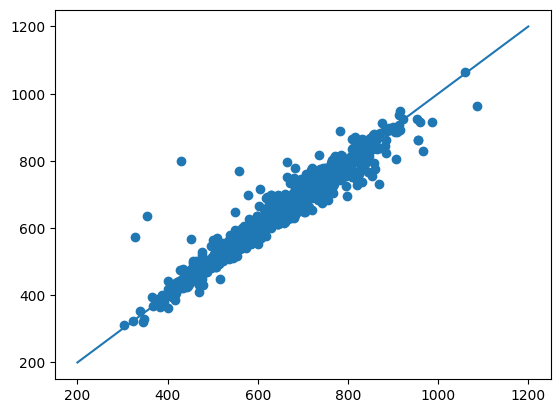

In [98]:
# # prediction on each level
y_simp_tog = y_pred_cal(G, fog_simp[0], fog_simp[1:], 0, 0, prop_tag)

# y_simp_tog = y_pred_cal(G, [fog_simp[0], fog_simp[1], fog_simp[2]], fog_simp[3:], 0, 0, prop_tag)

# y_simp_sog = uni_const * np.exp(G_sog,theta_ini[:nr_fog+nr_sog])
# y_simp_tog = uni_const * np.exp(np.matmul(G,theta_ini))
# calculate mae and r2 for each level
tog_simp_r2 = r2_score(y,y_simp_tog)
tog_simp_mae = mean_absolute_error(y,y_simp_tog)
tog_simp_are = np.average(np.abs((y - y_simp_tog) / y))*100
tog_simp_mre = np.median(np.abs((y - y_simp_tog) / y))*100
# printing
print('mae of tog:' + str(tog_simp_mae))
print('r2 of tog:' + str(tog_simp_r2))

print('are of tog:' + str(tog_simp_are))

# plot
plt.scatter(y,y_simp_tog)
plt.plot([200,1200],[200,1200])
# plt.savefig('Parity Plot of y_simp_tog and y_true for '+prop_tag+'.pdf')
plt.show()

In [99]:
# define the functions
def fog_residuals(fog_params, G, y):
    """
    
    :param y_exp: 
    :param y_pred: 
    :return: 
    """
    y_pred = y_pred_cal(G, fog_params[0], fog_params[1:], 0, 0, prop_tag)
#     y_pred = y_pred_cal(G, [fog_params[0], fog_params[1], fog_params[2]], fog_params[3:], 0, 0, prop_tag)
    
    errors = y-y_pred
    return errors

result_lm_fog = least_squares(fog_residuals, fog_simp, args=(G, y), method='lm', verbose=2)
fog_lm = result_lm_fog.x

`ftol` termination condition is satisfied.
Function evaluations 1794, initial cost 5.3892e+05, final cost 5.3823e+05, first-order optimality 1.51e+00.


mae of tog:14.58716778691674
r2 of tog:0.9434713572603138
are of tog:2.3321390029068336


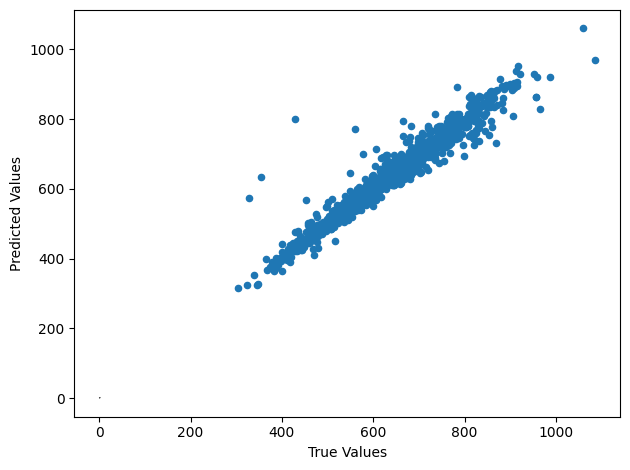

In [100]:
# prediction on each level
y_lm_tog = y_pred_cal(G, fog_lm[0], fog_lm[1:], 0, 0, prop_tag)

# y_lm_fog = y_pred_cal(G_fog, [fog_lm[0],fog_lm[1],fog_lm[2]], fog_lm[3:], 0, 0, prop_tag)


# calculate mae and r2 for each level
tog_lm_r2 = r2_score(y,y_lm_tog)
tog_lm_mae = mean_absolute_error(y,y_lm_tog)
tog_lm_are = np.average(np.abs((y - y_lm_tog) / y))*100
# printing

print('mae of tog:' + str(tog_lm_mae))
print('r2 of tog:' + str(tog_lm_r2))
print('are of tog:' + str(tog_lm_are))

# plot
plt.scatter(y,y_lm_tog,s=20)
plt.plot([0, 2.5], [0, 2.5], color='black', linestyle='--',linewidth=0.8)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

# plt.savefig('Parity Plot of y_lm_tog and y_true for '+prop_tag+'.pdf')
plt.show()

In [101]:
df_res = pd.DataFrame(columns=['Method', 'R2', 'MAE','ARE','MRE'])

df_res.at[0,'Method'] = 'Initial Guess'
df_res.at[0, 'R2'] = tog_0_r2
df_res.at[0, 'MAE'] = tog_0_mae
df_res.at[0, 'ARE'] = tog_0_are
df_res.at[0, 'MRE'] = tog_0_mre
df_res.at[1,'Method'] = 'Simplex Method'
df_res.at[1, 'R2'] = tog_simp_r2
df_res.at[1, 'MAE'] = tog_simp_mae
df_res.at[1, 'ARE'] = tog_simp_are
df_res.at[2,'Method'] = 'LM Method'
df_res.at[2, 'R2'] = tog_lm_r2
df_res.at[2, 'MAE'] = tog_lm_mae
df_res.at[2, 'ARE'] = tog_lm_are

with pd.ExcelWriter(prop_tag+'_Results.xlsx') as writer:
    df_res.to_excel(writer, sheet_name='Performance Overview', index=False)

In [102]:
theta_lm = fog_lm
df_theta = pd.DataFrame(theta_lm)

df_theta.to_excel('data/theta_'+prop_tag+'.xlsx', index=False)